# Ectopy: Ectopic expression analysis in Python

The code below presents a typical pipeline of `ectopy` package to calculate activation frequencies of ectopically expressed genes and to find potential prognostic biomarkers.

## Import data

In [1]:
import pandas as pd
data_dir = 'data/'
data = pd.read_csv(data_dir + 'data.csv', sep=';', index_col='id_sample')
expgroup = pd.read_csv(data_dir + 'expgroup.csv', sep=';', index_col='id_sample')

Display data.

In [2]:
print('Data', data.shape)
data.head(3)

Data (1144, 3)


,DNMT3B,EXO1,MCM10
id_sample,,,
TCGA-3C-AAAU-01A,2.293107,1.851411,1.472214
TCGA-3C-AALI-01A,2.213523,2.893140,2.099413
TCGA-3C-AALJ-01A,3.160032,1.735396,1.655712


Display a list of available genes.

In [3]:
genes = list(data.columns)
print('Available genes', genes)

Available genes ['DNMT3B', 'EXO1', 'MCM10']


Display expgroup with tissue status (column `group`) and survival data (columns `time` and `event`).

In [4]:
print('Expgroup', expgroup.shape)
expgroup.head(3)

Expgroup (1144, 3)


,group,time,event
id_sample,,,
TCGA-3C-AAAU-01A,tumoral,134.90,0.0
TCGA-3C-AALI-01A,tumoral,133.50,0.0
TCGA-3C-AALJ-01A,tumoral,49.13,0.0


## Create normal and tumoral datasets

In [5]:
expgroup_normal = expgroup[expgroup['group']=='normal']
expgroup_tumoral = expgroup[expgroup['group']=='tumoral']
normal = data.loc[expgroup_normal.index, :]
tumoral = data.loc[expgroup_tumoral.index, :]

In [6]:
print('Tumoral:', 'data', tumoral.shape, 'expgroup', expgroup_tumoral.shape)
print('Normal:', 'data', normal.shape, 'expgroup', expgroup_normal.shape)

Tumoral: data (1047, 3) expgroup (1047, 3)
Normal: data (97, 3) expgroup (97, 3)


## Calculate m2sd threshold

In [7]:
from analysis import threshold
m2sd_threshold = threshold.StdDecorator(threshold.MeanTreshold(normal), nb_std=2).calculate_threshold()
print('Threshold m2sd')
print(m2sd_threshold)

Threshold m2sd
DNMT3B    1.396983
EXO1      1.089280
MCM10     0.898020
dtype: float64


## Calculate frequencies of expression above a threshold

In [8]:
from analysis import expression_analysis
frequency = expression_analysis.ExpressionFrequency().calculate_expression_frequency(tumoral, m2sd_threshold)
print('Activation frequency obtained with m2sd threshold in percentage')
print(frequency.head())

Activation frequency obtained with m2sd threshold in percentage
DNMT3B    45.367717
EXO1      81.088825
MCM10     73.925501
dtype: float64


<AxesSubplot:>

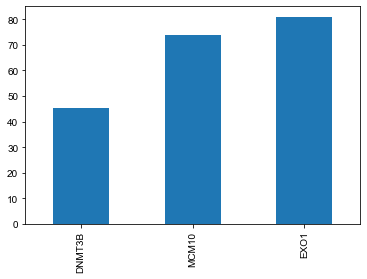

In [28]:
frequency.sort_values().plot.bar()

## Plot Kaplan-Meier survival curve using a threshold

In [19]:
from service import plot_service

### m2sd threshold

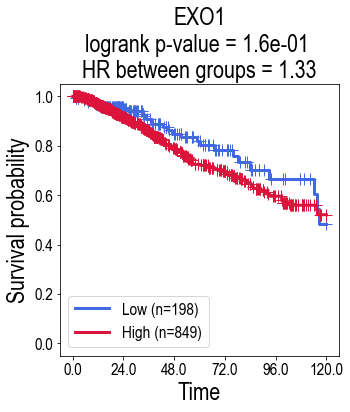

In [30]:
fig = plot_service.plot_individual_survival(tumoral, 'EXO1', m2sd_threshold, expgroup_tumoral, 'time', 'event', 120)

### Median threshold in tumoral samples

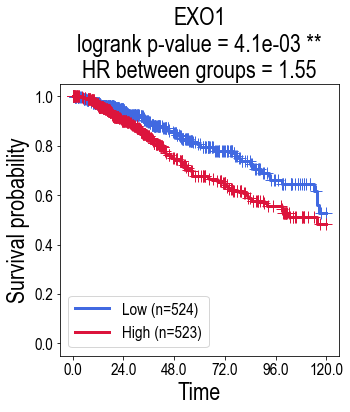

In [22]:
median_threshold = threshold.PercentileThreshold(tumoral, 50).calculate_threshold()
fig = plot_service.plot_individual_survival(tumoral, 'EXO1', median_threshold, expgroup_tumoral, 'time', 'event', 120)

## Calculate adaptive threshold

In [10]:
from analysis import threshold

In [11]:
max_normal = threshold.MaxTreshold(normal).calculate_threshold()

In [12]:
options = {
    'percentile': 15.0,
    'step_percentile': 1.0,
    'min_nb_samples': 20,
    'noise_level': 0.3,
    'min_reference_threshold': max_normal,
    'nb_folds': 5,
    'nb_cross_validations': 1
    }


In [13]:
adaptive_threshold = threshold.AdaptiveThreshold(data=tumoral, survival_data=expgroup_tumoral, duration_col='time', event_col='event', **options)
adaptive = adaptive_threshold.calculate_threshold()

Processing feature DNMT3B
Optimal threshold for DNMT3B
     threshold  threshold_percentile   p_value  hazard_ratio  validated  \
T11   1.787853             72.464183  0.003263      1.557107       True   

     cv_score  optimal  
T11      20.0     True  
Processing feature EXO1
Optimal threshold for EXO1
     threshold  threshold_percentile   p_value  hazard_ratio  validated  \
T13   2.126367             58.704871  0.003706      1.527854       True   

     cv_score  optimal  
T13      40.0     True  
Processing feature MCM10
Optimal threshold for MCM10
    threshold  threshold_percentile   p_value  hazard_ratio  validated  \
T5   1.655761             57.486151  0.003297      1.537064       True   

    cv_score  optimal  
T5      20.0     True  


In [14]:
print('Adaptive threshold')
adaptive.head()

Adaptive threshold


DNMT3B    1.787853
EXO1      2.126367
MCM10     1.655761
dtype: float64

## Display details for tested thresholds

In [15]:
adaptive_threshold.get_details('EXO1').head(15)

,threshold,threshold_percentile,p_value,hazard_ratio,validated,cv_score,optimal
T1,1.813697,46.704871,0.025297,1.396049,True,0.0,False
T2,1.846114,47.704871,0.014063,1.442413,True,0.0,False
T3,1.860113,48.704871,0.006309,1.501328,True,20.0,False
T4,1.899769,49.704871,0.011484,1.452290,True,20.0,False
T5,1.921833,50.704871,0.008367,1.474996,True,0.0,False
T6,1.945113,51.704871,0.007588,1.481416,True,20.0,False
T7,1.964816,52.704871,0.002709,1.554961,True,40.0,False
T8,2.003815,53.704871,0.003130,1.542375,True,40.0,False
T9,2.024925,54.704871,0.003049,1.543227,True,40.0,False
T10,2.053258,55.704871,0.002321,1.561623,True,20.0,False


## Plot Kaplan-Meier individual survival curve for a gene using the adaptive threshold

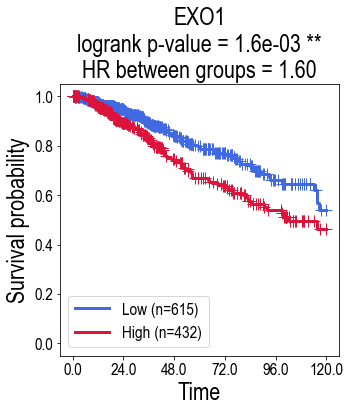

In [16]:
fig = plot_service.plot_individual_survival(tumoral, 'EXO1', adaptive, expgroup_tumoral, 'time', 'event', 120)

## Plot Kaplan-Meier combined survival curve for a panel of genes using the adaptive threshold

In [25]:
panel = ['DNMT3B', 'EXO1', 'MCM10']
prognosis_groups = {'P1': [0, 0], 'P2': [1, 2], 'P3': [3, len(panel)]} 
print('Prognosis groups', prognosis_groups)

Prognosis groups {'P1': [0, 0], 'P2': [1, 2], 'P3': [3, 3]}


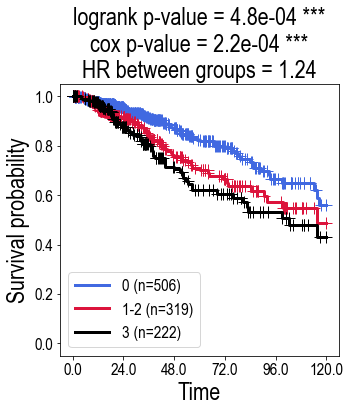

In [26]:
fig = plot_service.plot_combined_survival(tumoral, panel, prognosis_groups, adaptive, expgroup_tumoral, 'time', 'event', 120)